### The goal of this notebook is to determine whether the results from Pete's LC-MS analyses explain any of the microbial community data

In [2]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [3]:
%%R
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)
library(reshape)

/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: permute

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: This is vegan 2.4-1

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The follo

In [4]:
%%R
# We will need a table of relative abundances for all our samples.
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq = transform_sample_counts(physeq, function(x) x / sum(x))

In [5]:
%%R
OTUtab = as.matrix(otu_table(physeq))
head(OTUtab)

OTU Table:          [6 taxa and 72 samples]
                     taxa are rows
                         27           57           35           59           91
16SW83_1069699 0.000000e+00 0.000000e+00 0.0000000000 1.738586e-05 0.000000e+00
16SW15_380479  0.000000e+00 0.000000e+00 0.0000000000 0.000000e+00 0.000000e+00
16SW73_374389  8.241645e-05 4.890215e-05 0.0000000000 3.477172e-05 2.612671e-05
16SW87_1469358 0.000000e+00 0.000000e+00 0.0000000000 0.000000e+00 0.000000e+00
16SW13_1202991 0.000000e+00 0.000000e+00 0.0000000000 1.738586e-05 0.000000e+00
16SW139_208607 8.241645e-05 1.467064e-04 0.0001366214 8.692931e-05 5.225343e-05
                        133           93           83            3           73
16SW83_1069699 5.359631e-05 0.0000000000 5.577711e-05 0.000000e+00 0.000000e+00
16SW15_380479  0.000000e+00 0.0000000000 0.000000e+00 0.000000e+00 0.000000e+00
16SW73_374389  0.000000e+00 0.0000000000 5.577711e-05 2.930575e-05 5.857716e-05
16SW87_1469358 0.000000e+00 0.0000000000 

In [6]:
%%R
SamizDatTab = data.frame(sample_data(physeq))
SamizDatTab$Day = revalue(SamizDatTab$Day, c("7"="7.5", "5"="5.5", "3"="3.5","2"="2","1"="1","0"="0"))
head(SamizDatTab)

    Cosm Trtmt Day
27     6     N   2
57    23     N 7.5
35     6     N   0
59    23     N   0
91     5     X 5.5
133   27     N   2


In [104]:
%%R
write.csv(d.melt,file="../../../LC-MS/LCMSPeakAreaStacked.csv")

In [7]:
%%R
# We will also need the LC-MS data, corresponding to each root location and N treatment.
# We will use the averaged values from LC-MS data to match to the community values, because the samples were not paired.
d.melt = read.csv("../../../LC-MS/LCMSPeakAreaStacked.csv")
d.melt.rm = d.melt[d.melt$NEGname!="21S_NEG.mzML",]
# Removing a consistent outlier
d.melt.rm.map = d.melt.rm %>%
    group_by(Trtmt,Day,Class,Cmpd)%>%
    summarize(Mean = mean(PeakArea))%>%
    group_by(Cmpd)%>%
    mutate(PeakAreaScaled = Mean / mean(Mean))
d.melt.rm.map$Day = as.factor(d.melt.rm.map$Day)
head(d.melt.rm.map)
# Creates a new value that is the mean value for each compound, under each treatment and day
# and rescales it by the mean of all of that compound across treatment/days.

Source: local data frame [6 x 6]
Groups: Cmpd [6]

   Trtmt    Day  Class              Cmpd      Mean PeakAreaScaled
  <fctr> <fctr> <fctr>            <fctr>     <dbl>          <dbl>
1      N      0     AA     alpha.alanine  645417.1      0.7316449
2      N      0     AA   alpha.alanine.1 2048404.8      0.8216189
3      N      0     AA aminovaleric.acid 2139216.0      1.0176123
4      N      0     AA          arginine 6511037.9      1.5053518
5      N      0     AA        asparagine  496076.0      0.6329496
6      N      0     AA         aspartate  245202.8      0.3320739


In [8]:
%%R
# We need to integrate that data to our sample data.
# First, we will generate a table with the sample ID and its corresponding LC-MS data.
# I think I could use join to do this.
SamizDatTab$ID = row.names(SamizDatTab)
SamizDatLCMS = left_join(data.frame(SamizDatTab),data.frame(d.melt.rm.map))
head(SamizDatLCMS)

/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Joining, by = c("Trtmt", "Day")

  warnings.warn(x, RRuntimeWarning)


  Cosm Trtmt Day ID Class              Cmpd      Mean PeakAreaScaled
1    6     N   2 27    AA     alpha.alanine  862555.5      0.9777930
2    6     N   2 27    AA   alpha.alanine.1 2287484.3      0.9175142
3    6     N   2 27    AA aminovaleric.acid 2180164.1      1.0370911
4    6     N   2 27    AA          arginine 6356189.9      1.4695509
5    6     N   2 27    AA        asparagine 1011882.3      1.2910735
6    6     N   2 27    AA         aspartate  645089.3      0.8736331


In [9]:
%%R
# Now we need to melt and recast that dataframe so that the Cmpd goes across the columns as a factor,
# and the scaled peak area is maintained
SamizDatLCMSIntegrated <- cast(SamizDatLCMS, ID+Cosm+Trtmt+Day~Cmpd)
# Note we lose Class... not sure how to do this well, but can easily integrate it later.
row.names(SamizDatLCMSIntegrated)=SamizDatLCMSIntegrated$ID
SampleDat = SamizDatLCMSIntegrated

/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Using PeakAreaScaled as value column.  Use the value argument to cast to override this choice

  warnings.warn(x, RRuntimeWarning)


In [10]:
%%R
CA = CCA$CA
# Has properties $u (sample IDs vs CAs), $eig (eigen values of CAs 1-60), $v (OTUs vs CAs), $Xbar (sample IDs vs OTUs)
# 



Error in withVisible({ : object 'CCA' not found


/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in withVisible({ : object 'CCA' not found

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: There were 17 warnings (use warnings() to see them)
  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


In [12]:
%%R
levels(as.factor(colnames(OTUtab)))==levels(as.factor(row.names(SampleDat)))
# We have the same samples in our OTU table as in the sample data - check.

 [1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE


In [45]:
%%R
colnames(SampleDat)

 [1] "ID"                                    
 [2] "Cosm"                                  
 [3] "Trtmt"                                 
 [4] "Day"                                   
 [5] "Acetylcarnitine"                       
 [6] "adenine"                               
 [7] "adenine.1"                             
 [8] "alpha.alanine"                         
 [9] "alpha.alanine.1"                       
[10] "alpha.ketoglutaric.acid"               
[11] "alpha.ketoglutaric.acid.1"             
[12] "aminovaleric.acid"                     
[13] "arginine"                              
[14] "asparagine"                            
[15] "aspartate"                             
[16] "Betaine"                               
[17] "biotin"                                
[18] "Calcium.pantothenate.pantothenic.acid."
[19] "Carnitine_2"                           
[20] "Cholinesulfate"                        
[21] "cytidine"                              
[22] "deoxyadenosine"             

In [93]:
%%R
Factors = str(cat(paste(colnames(SampleDat[,5:(dim(SampleDat)[2]-1)]),"+")))

Acetylcarnitine + adenine + adenine.1 + alpha.alanine + alpha.alanine.1 + alpha.ketoglutaric.acid + alpha.ketoglutaric.acid.1 + aminovaleric.acid + arginine + asparagine + aspartate + Betaine + biotin + Calcium.pantothenate.pantothenic.acid. + Carnitine_2 + Cholinesulfate + cytidine + deoxyadenosine + fructose + fumaric.acid + glucose + glutamate + glutamate.1 + glycolic.acid + guanine + inosine + inosine.1 + isoleucine + isoleucine.1 + L.Citrulline + L.Citrulline.1 + L.tyrosine + L.tyrosine.1 + lactic.acid + leucine + leucine.1 + lysine + malonic.acid + maltose.cellobiose + mannitol + N.acetyl.D.glucosamine + N.acetyl.D.glucosamine.1 + nicotinic.acid + phenylalanine + phenylalanine.1 + proline + proline.1 + rhamnose + ribose + salicylic.acid + serine + serine.1 + shikimic.acid + succinic.acid + sucrose + Tetrasaccharide1 + Tetrasaccharide2 + trehalose + Trisaccharide1 + Trisaccharide2 + Trisaccharide3 + Trisaccharide4 + Uracil + Urea + uridine + uridine.1 + valine + valine.1 + NULL


In [99]:
%%R
# Okay, now we have our table of factors that we want to relate, with the correct rownames being the sample IDs.
# I think we are ready for CA
CCA = cca(t(OTUtab),SampleDat[5:73])
#vare.cca <- cca(varespec ~ Al + P*(K + Baresoil), data=varechem)
CCA

Call: cca(X = t(OTUtab), Y = SampleDat[5:73])

              Inertia Proportion Rank
Total         0.26454    1.00000     
Constrained   0.04133    0.15625   11
Unconstrained 0.22320    0.84375   60
Inertia is mean squared contingency coefficient 

Eigenvalues for constrained axes:
    CCA1     CCA2     CCA3     CCA4     CCA5     CCA6     CCA7     CCA8 
0.007176 0.004206 0.003930 0.003857 0.003661 0.003457 0.003269 0.003199 
    CCA9    CCA10    CCA11 
0.003145 0.002860 0.002572 

Eigenvalues for unconstrained axes:
     CA1      CA2      CA3      CA4      CA5      CA6      CA7      CA8 
0.020588 0.008917 0.006985 0.006712 0.005586 0.005143 0.004958 0.004697 
(Showed only 8 of all 60 unconstrained eigenvalues)



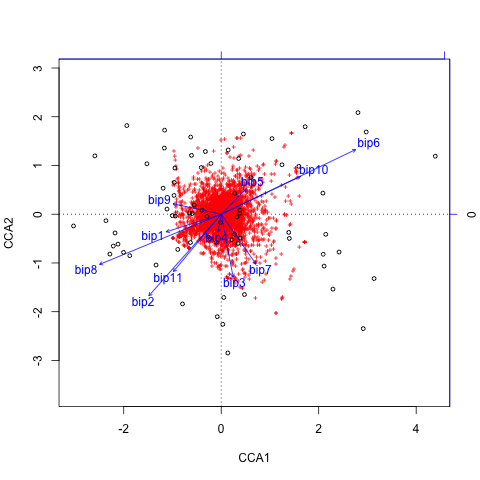

In [100]:
%%R
ourplot = plot(CCA)
# This shows the CCA results, with the LCMS data in vectors, the samples as points, and the OTUs as +s

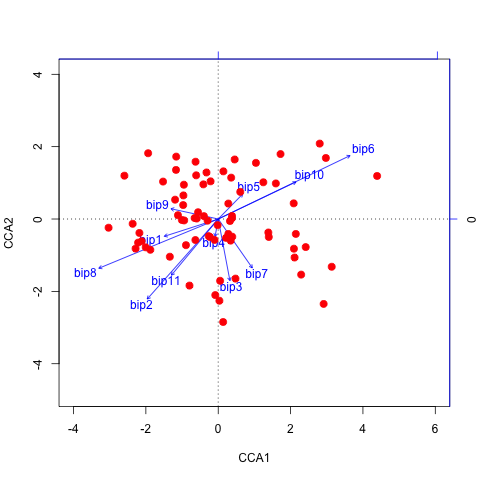

In [101]:
%%R
plot(CCA,choices=c(1,2),display=c("wa","bp"),type="points",xlim=c(-4,6),scaling=2)
points(CCA,disp="sites",pch=21,col="red",bg="red",cex=1.3)
#text(CCA,"sites",pos=3,axis.bp=TRUE)

In [16]:
%%R
sample_data(physeq) = sample_data(data.frame(SampleDat[,2:dim(SampleDat)[2]]))

In [17]:
%%R
sample_data(physeq)$Day = as.numeric(sample_data(physeq)$Day)

In [27]:
%%R
dim(otu_table(physeq))

[1] 5452   72


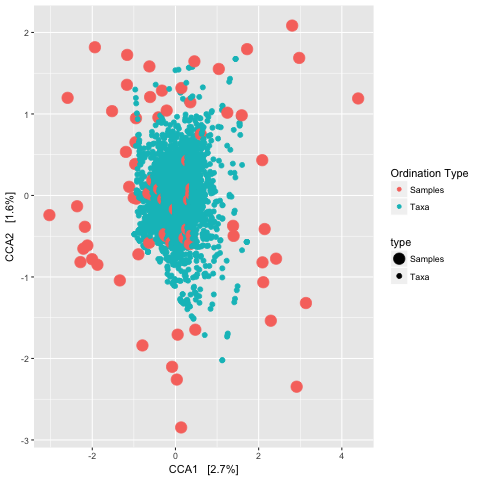

In [102]:
%%R
#CCAgg = cca(, data=physeq, "CCA")
#varespec ~ Al + P*(K + Baresoil), data=varechem
p = plot_ordination(physeq,CCA, type = "biplot")
p

In [33]:
%%R
# Now add the environmental variables as arrows
arrowmat = scores(CCA)
# Add labels, make a data.frame
arrowdf = data.frame(labels = rownames(arrowmat), arrowmat)
# Define the arrow aesthetic mapping
arrow_map = aes(xend = CA1, yend = CA2, x = 0, y = 0, shape = NULL, color = NULL, 
    label = labels)
label_map = aes(x = 1.2 * CA1, y = 1.2 * CA2, shape = NULL, color = NULL, 
    label = labels)
# Make a new graphic
arrowhead = arrow(length = unit(0.05, "npc"))
p1 = p + geom_segment(arrow_map, size = 0.5, data = arrowdf, color = "gray", 
    arrow = arrowhead) + geom_text(label_map, size = 2, data = arrowdf)
p1


Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE,  : 
  arguments imply differing number of rows: 5452, 72, 1


/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE,  : 
  arguments imply differing number of rows: 5452, 72, 1

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: In plot_ordination(CCA, type = "biplot") :
  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Full functionality requires `physeq` be phyloseq-class